In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os


In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [3]:
from masa_utils import PsuedoLog
from masa_utils import InducedPolarization
from masa_utils import debye_res_t
from masa_utils_pytorch import Pelton_res_f
from masa_utils_pytorch import Pelton_con_f
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Optimization

# Debey Model resistivity form

In [68]:
res0= 1.0
con8 = 2.0
eta= 0.5
tau= 0.01 #0.001
expc=1.0
parm_true = torch.tensor([np.log(res0), eta, np.log(tau), expc], dtype=torch.float32, requires_grad=False)
ip_model = Pelton_res_f()
sim = InducedPolarizationSimulation(ip_model=ip_model, mode="sip_t")
print(sim.ip_model)

In [69]:
# logstrt = -4
# logend = 0
# logstep =0.1
# windows_cen = 10**np.arange(logstrt,logend,logstep)
# nwindows = windows_cen.shape[0]
# print(windows_cen)
# sim.get_windows(windows_cen)

# print(sim.windows_strt)
# print(sim.windows_end)


In [70]:
logstrt = -4
logend = 0
logstep =0.1
windows_cen = np.r_[0, 10**np.arange(logstrt,logend,logstep)]
nwindows = windows_cen.shape[0]

sim.get_windows(windows_cen)
windows_strt = sim.windows_strt
windows_end = sim.windows_end
windows_strt[:2] = 10*eps*torch.tensor(np.r_[-1,1])
windows_end[0] = 10*eps*torch.tensor(1.0)
sim.windows_strt = windows_strt
sim.windows_end = windows_end

In [71]:
# print(sim.windows_strt)
# print(sim.windows_end)

In [72]:
dpred = sim.dpred(parm_true)
dt = (sim.times[1]-sim.times[0]).detach().numpy()
dpred_plot= dpred.detach().numpy()
dpred_plot[0]*=dt

print(dpred_plot)


[ 5.00488043e-01  5.03989716e+01  4.93097382e+01  4.91419106e+01
  4.89621506e+01  4.86152382e+01  4.84238701e+01  4.80397797e+01
  4.74851990e+01  4.69277191e+01  4.61666946e+01  4.52154312e+01
  4.40350533e+01  4.26062775e+01  4.08521805e+01  3.87557526e+01
  3.63031616e+01  3.34171944e+01  3.01075096e+01  2.64230576e+01
  2.23936043e+01  1.81849861e+01  1.40024166e+01  1.00864162e+01
  6.68223906e+00  3.97994232e+00  2.07568693e+00  9.16954398e-01
  3.29150200e-01  9.12941843e-02  1.83414891e-02  2.46425369e-03
  2.00986862e-04  1.02443155e-05 -2.34169420e-07  5.07832738e-07
 -2.34067556e-07  5.20172762e-07 -1.12984708e-07 -1.77676014e-07
  1.82866643e-07]


In [73]:
window_mat = sim.window_mat
print(sim.window_mat)

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [74]:
dpred_J =sim.J(parm_true)
J_plot = dpred_J.detach().numpy()
J_plot[0,:] *=dt
print(J_plot)

[[ 5.0048804e-01 -9.9902385e-01 -4.8789455e-04 -3.6019182e-03]
 [ 5.0398987e+01  1.0079797e+02 -5.0108288e+01 -2.3754074e+02]
 [ 4.9309769e+01  9.8619385e+01 -4.8683086e+01 -1.8315671e+02]
 [ 4.9141945e+01  9.8284058e+01 -4.8325542e+01 -1.6848180e+02]
 [ 4.8962143e+01  9.7924667e+01 -4.7957653e+01 -1.5669170e+02]
 [ 4.8615307e+01  9.7230392e+01 -4.7377655e+01 -1.4376277e+02]
 [ 4.8423866e+01  9.6847687e+01 -4.6863865e+01 -1.3098782e+02]
 [ 4.8039810e+01  9.6079514e+01 -4.6071785e+01 -1.1699678e+02]
 [ 4.7485252e+01  9.4970413e+01 -4.5072208e+01 -1.0340376e+02]
 [ 4.6927681e+01  9.3855392e+01 -4.3950001e+01 -9.0053940e+01]
 [ 4.6166691e+01  9.2333435e+01 -4.2472038e+01 -7.5595062e+01]
 [ 4.5215466e+01  9.0430862e+01 -4.0669342e+01 -6.1086365e+01]
 [ 4.4035049e+01  8.8070122e+01 -3.8447151e+01 -4.6270584e+01]
 [ 4.2606274e+01  8.5212540e+01 -3.5788010e+01 -3.1696304e+01]
 [ 4.0852200e+01  8.1704338e+01 -3.2601406e+01 -1.7373550e+01]
 [ 3.8755760e+01  7.7511513e+01 -2.8888620e+01 -3.87344

In [75]:
# windows_plot = np.r_[0,windows_cen]
windows_plot = windows_cen

print(windows_plot)

[0.00000000e+00 1.00000000e-04 1.25892541e-04 1.58489319e-04
 1.99526231e-04 2.51188643e-04 3.16227766e-04 3.98107171e-04
 5.01187234e-04 6.30957344e-04 7.94328235e-04 1.00000000e-03
 1.25892541e-03 1.58489319e-03 1.99526231e-03 2.51188643e-03
 3.16227766e-03 3.98107171e-03 5.01187234e-03 6.30957344e-03
 7.94328235e-03 1.00000000e-02 1.25892541e-02 1.58489319e-02
 1.99526231e-02 2.51188643e-02 3.16227766e-02 3.98107171e-02
 5.01187234e-02 6.30957344e-02 7.94328235e-02 1.00000000e-01
 1.25892541e-01 1.58489319e-01 1.99526231e-01 2.51188643e-01
 3.16227766e-01 3.98107171e-01 5.01187234e-01 6.30957344e-01
 7.94328235e-01]


# code for numpy

In [76]:
sim_debye = debye_res_t(times=windows_plot)
p = np.r_[np.log(res0),eta,np.log(tau)]
dpred_debye = sim_debye.t(p)
dpred_debye_grad = sim_debye.t_grad(p)
print(dpred_debye_grad.shape)
print(dpred_debye.shape)

(41, 3)
(41,)


In [77]:
sim_debye = debye_res_t(times=sim.times)
window_mat = sim.window_mat.detach().numpy()
dpred_debye = window_mat@sim_debye.t(p)
dpred_debye_grad = window_mat@sim_debye.t_grad(p)
print(dpred_debye_grad.shape)
print(dpred_debye.shape)

(41, 3)
(41,)


# Plot

In [78]:
PL_pelton = PsuedoLog(
            logmin=1e0,
            linScale=1.0,
            logminx=10.**np.floor(np.log10(windows_plot[windows_plot>eps].min())),
            linScalex=0.1)
PL_jac = PsuedoLog(
            logmin=1e0,
            linScale=1.0,
            logminx=10.**np.floor(np.log10(windows_plot[windows_plot>eps].min())),
            linScalex=0.1)

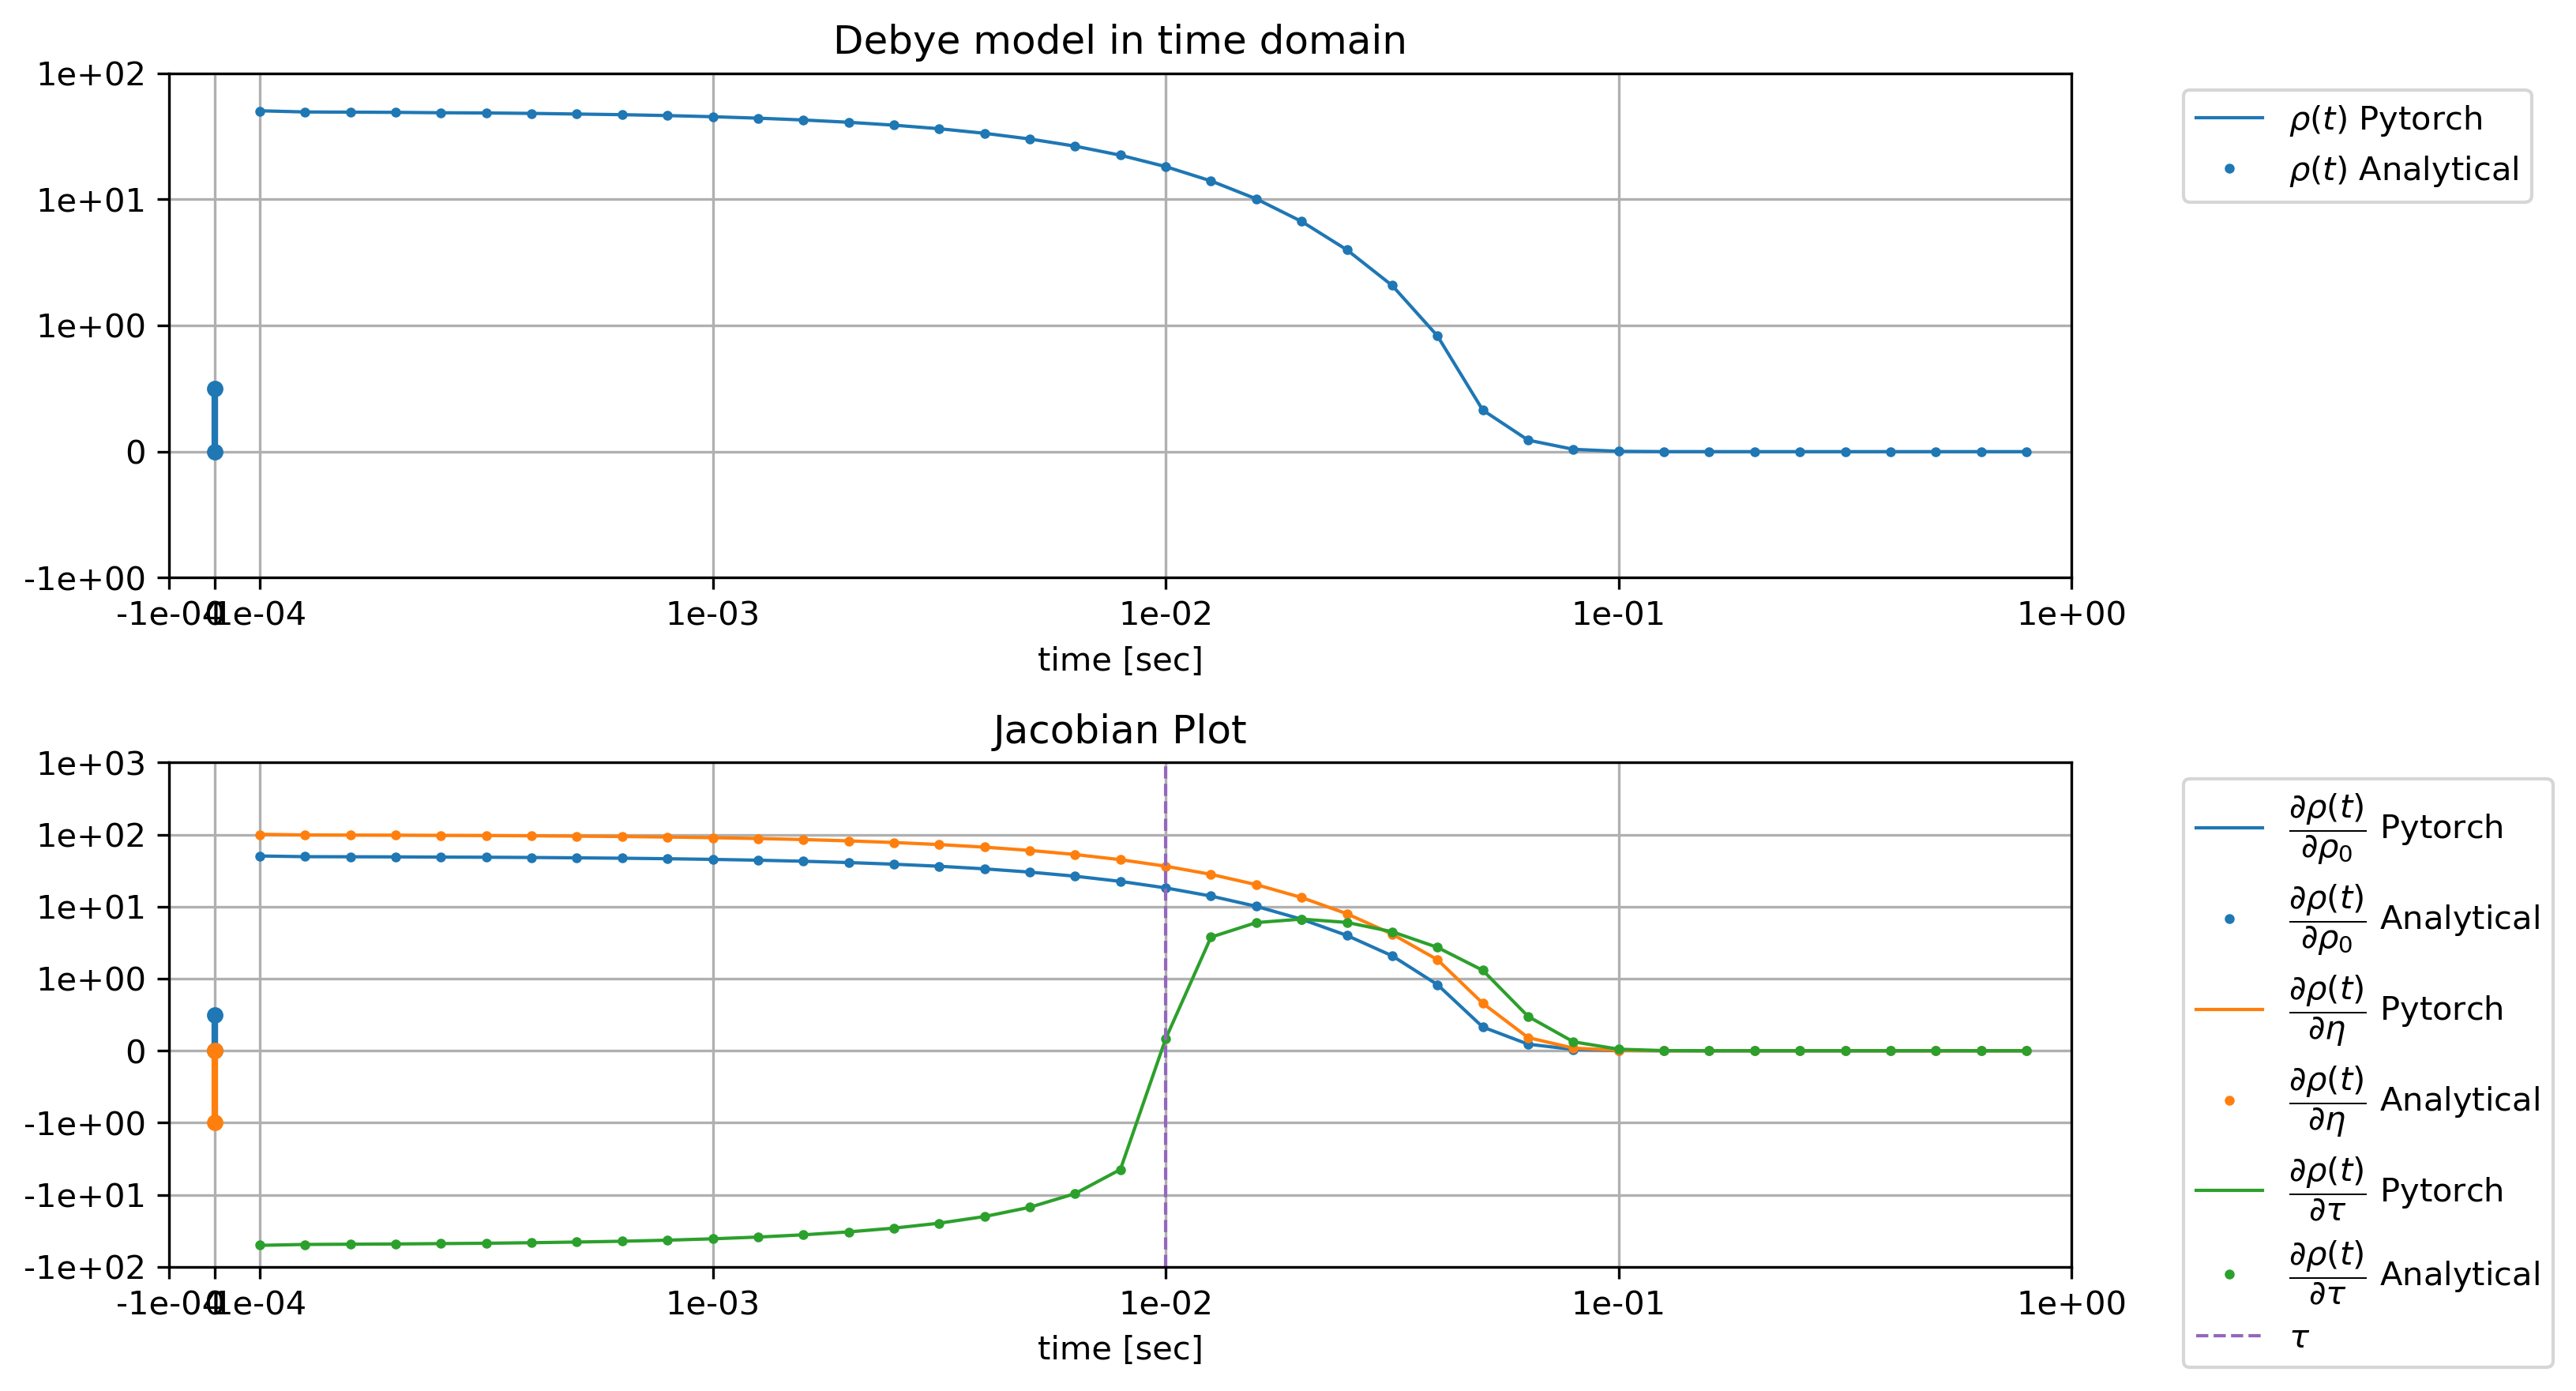

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(11, 6),dpi=300)
ax[0] = PL_pelton.plpl_plot(x=np.r_[0,0], y=np.r_[0,dpred_plot[0]], ax=ax[0], 
                linewidth=2.0,  color="C0") 
ax[0] = PL_pelton.plpl_plot(x=np.r_[0,0], y=np.r_[0, dpred_debye[0] ], ax=ax[0], 
                linestyle="", color="C0", marker='o',  markersize=4) 
ax[0] = PL_pelton.plpl_plot(x=windows_plot[1:], y=dpred_plot[1:], ax=ax[0],
                  color = "C0",label=r"$\rho(t)$ Pytorch")
ax[0] = PL_pelton.plpl_plot(x=windows_plot[1:], y=dpred_debye[1:], ax=ax[0],
                  color = "C0",marker=".",markersize=4,linestyle="",label=r"$\rho(t)$ Analytical")
PL_pelton.pl_axes(ax=ax[0])
PL_pelton.pl_axes_x(ax=ax[0])
ax[1] = PL_jac.plpl_plot(x=np.r_[0,0], y=np.r_[0,J_plot[0,0]], ax=ax[1], 
                linewidth=2.0,  color="C0" ) 
ax[1] = PL_jac.plpl_plot(x=np.r_[0,0], y=np.r_[0,dpred_debye_grad[0,0]], ax=ax[1], 
                linestyle="",  color="C0", marker='o', markersize=4) 
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,0], ax=ax[1],
                 color = "C0",label=r"$\dfrac{\partial\rho(t)}{\partial\rho_0}$ Pytorch")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=dpred_debye_grad[1:,0], ax=ax[1],
        color = "C0",marker=".",markersize=4, linestyle="",
        label=r"$\dfrac{\partial\rho(t)}{\partial\rho_0}$ Analytical")
ax[1] = PL_jac.plpl_plot(x=np.r_[0,0], y=np.r_[0,J_plot[0,1]], ax=ax[1],
                linewidth=2.0, color = "C1")
ax[1] = PL_jac.plpl_plot(x=np.r_[0,0], y=np.r_[0,dpred_debye_grad[0,1],], ax=ax[1],
                linestyle="", color = "C1",marker='o', markersize=4)
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,1], ax=ax[1],
                color = "C1",label=r"$\dfrac{\partial\rho(t)}{\partial\eta}$ Pytorch")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=dpred_debye_grad[1:,1], ax=ax[1],
        color = "C1",marker=".",markersize=4, linestyle="",
        label=r"$\dfrac{\partial\rho(t)}{\partial\eta}$ Analytical")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,2], ax=ax[1],
                color = "C2",label=r"$\dfrac{\partial\rho(t)}{\partial\tau}$ Pytorch")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=dpred_debye_grad[1:,2], ax=ax[1],
        color = "C2",marker=".",markersize=4, linestyle="",
        label=r"$\dfrac{\partial\rho(t)}{\partial\tau}$ Analytical")
ax[1] = PL_jac.pl_axvline(ax=ax[1], x=tau, color="C4",label=r'$\tau$')
PL_jac.pl_axes(ax=ax[1])
PL_jac.pl_axes_x(ax=ax[1])
for a in ax:
        a.set_xlabel('time [sec]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
# ax[0].set_title(fr"""Resistivity form of Pelton model in time domain
# Pytorch implementation Validated with Debye model
# $\rho_0$: {res0}, $\eta$: {eta}, $\tau$: {tau}, c {expc}""")
ax[0].set_title("Debye model in time domain")
ax[1].set_title('Jacobian Plot')
plt.tight_layout()
plt.savefig("16_AutoDiffValid_TDlP_Debye.jpg", dpi=300)

# Pelton model Conductivity form 

In [80]:
con8 = 5.0
eta= 0.5
tau= 0.01 
expc= 0.5
parm = torch.tensor([np.log(con8), eta, np.log(tau), expc], dtype=torch.float32, requires_grad=True)
ip_model = Pelton_con_f()
sim = InducedPolarizationSimulation(ip_model=ip_model, mode="sip_t")
print(sim.ip_model)

In [86]:
sim.window_mat = window_mat
sim.windows_strt = windows_strt
sim.windows_end = windows_end
sim.windows_width = windows_end-windows_strt

In [88]:
# logstrt = -4
# logend = 0
# logstep =0.1
# windows_cen = 10**torch.arange(logstrt,logend,logstep)
# #windows_cen = torch.arange(10**logstrt, 10**logend, 1e-4)
# nwindows = windows_cen.shape[0]
# print(windows_cen)
# sim.get_windows(windows_cen)
# print(sim.windows_strt)
# print(sim.windows_end)
# windows_plot = np.r_[0,windows_cen.detach().numpy()]
# print(windows_plot)

In [97]:
dpred = sim.dpred(parm)
dpred_J = sim.J(parm)
dpred_plot= dpred.detach().numpy()
J_plot = dpred_J.detach().numpy()

print(J_plot)

[[ 4.0488130e+06 -1.8720200e+05  2.3206918e+04  4.3240388e+05]
 [-3.9896738e+03 -1.4487254e+04  1.6269753e+03  1.1865962e+04]
 [-1.7121157e+03 -5.6193623e+03  5.4878119e+02  9.9914014e+02]
 [-1.4628807e+03 -4.6896973e+03  4.4098352e+02  3.8497412e+02]
 [-1.2409337e+03 -3.8728245e+03  3.4773932e+02 -8.3475342e+01]
 [-1.0491179e+03 -3.1784424e+03  2.7005121e+02 -4.0637402e+02]
 [-8.8209875e+02 -2.5855266e+03  2.0533188e+02 -6.1330774e+02]
 [-7.3675079e+02 -2.0807378e+03  1.5180927e+02 -7.3554572e+02]
 [-6.1191772e+02 -1.6585161e+03  1.0867026e+02 -7.8450391e+02]
 [-5.0453293e+02 -1.3059590e+03  7.4223694e+01 -7.8262177e+02]
 [-4.1313232e+02 -1.0161267e+03  4.7465382e+01 -7.4251794e+02]
 [-3.3565060e+02 -7.7997272e+02  2.7167873e+01 -6.7737805e+02]
 [-2.7054736e+02 -5.9035620e+02  1.2315321e+01 -5.9729218e+02]
 [-2.1627672e+02 -4.4017563e+02  1.9055462e+00 -5.1133521e+02]
 [-1.7141342e+02 -3.2305536e+02 -4.9428558e+00 -4.2538919e+02]
 [-1.3467180e+02 -2.3320389e+02 -9.0349960e+00 -3.44417

In [50]:
# sim_times = sim.times.detach().numpy()
# sim_times_resmp = torch.tensor(sim_times[1::10])
# print(len(sim_times_resmp))
# sim.get_windows(sim_times_resmp)
# dpred = sim.dpred(parm)
# dpred_J = sim.J(parm)
# dpred_plot= dpred.detach().numpy()
# J_plot = dpred_J.detach().numpy()
# print(J_plot)

In [ ]:
dt =(sim.times[1]-sim.times[0]).detach().numpy()
dpred_plot[0] *= dt
J_plot[0,:] *= dt
print(dpred_plot)


[ 2.47119904e+00 -3.98967480e+03 -1.71211707e+03 -1.46288074e+03
 -1.24093384e+03 -1.04911841e+03 -8.82099243e+02 -7.36750916e+02
 -6.11917969e+02 -5.04532684e+02 -4.13132446e+02 -3.35650696e+02
 -2.70547302e+02 -2.16276703e+02 -1.71413361e+02 -1.34671875e+02
 -1.04896652e+02 -8.09827728e+01 -6.19828644e+01 -4.70501328e+01
 -3.54265366e+01 -2.64742775e+01 -1.96482868e+01 -1.44912243e+01
 -1.06285992e+01 -7.75895214e+00 -5.64237309e+00 -4.09129667e+00
 -2.96107078e+00 -2.14144802e+00 -1.54947579e+00 -1.12332296e+00
 -8.17324400e-01 -5.97981215e-01 -4.40878868e-01 -3.28320861e-01
 -2.47556180e-01 -1.89408228e-01 -1.47297293e-01 -1.16558015e-01
 -9.49067026e-02]


In [100]:
PL_pelton = PsuedoLog(
            logmin=1e1,
            linScale=1.0,
            logminx=10.**np.floor(np.log10(windows_plot[windows_plot>eps].min())),
            linScalex=0.1)
PL_jac = PsuedoLog(
            logmin=1e1,
            linScale=1.0,
            logminx=10.**np.floor(np.log10(windows_plot[windows_plot>eps].min())),
            linScalex=0.1)

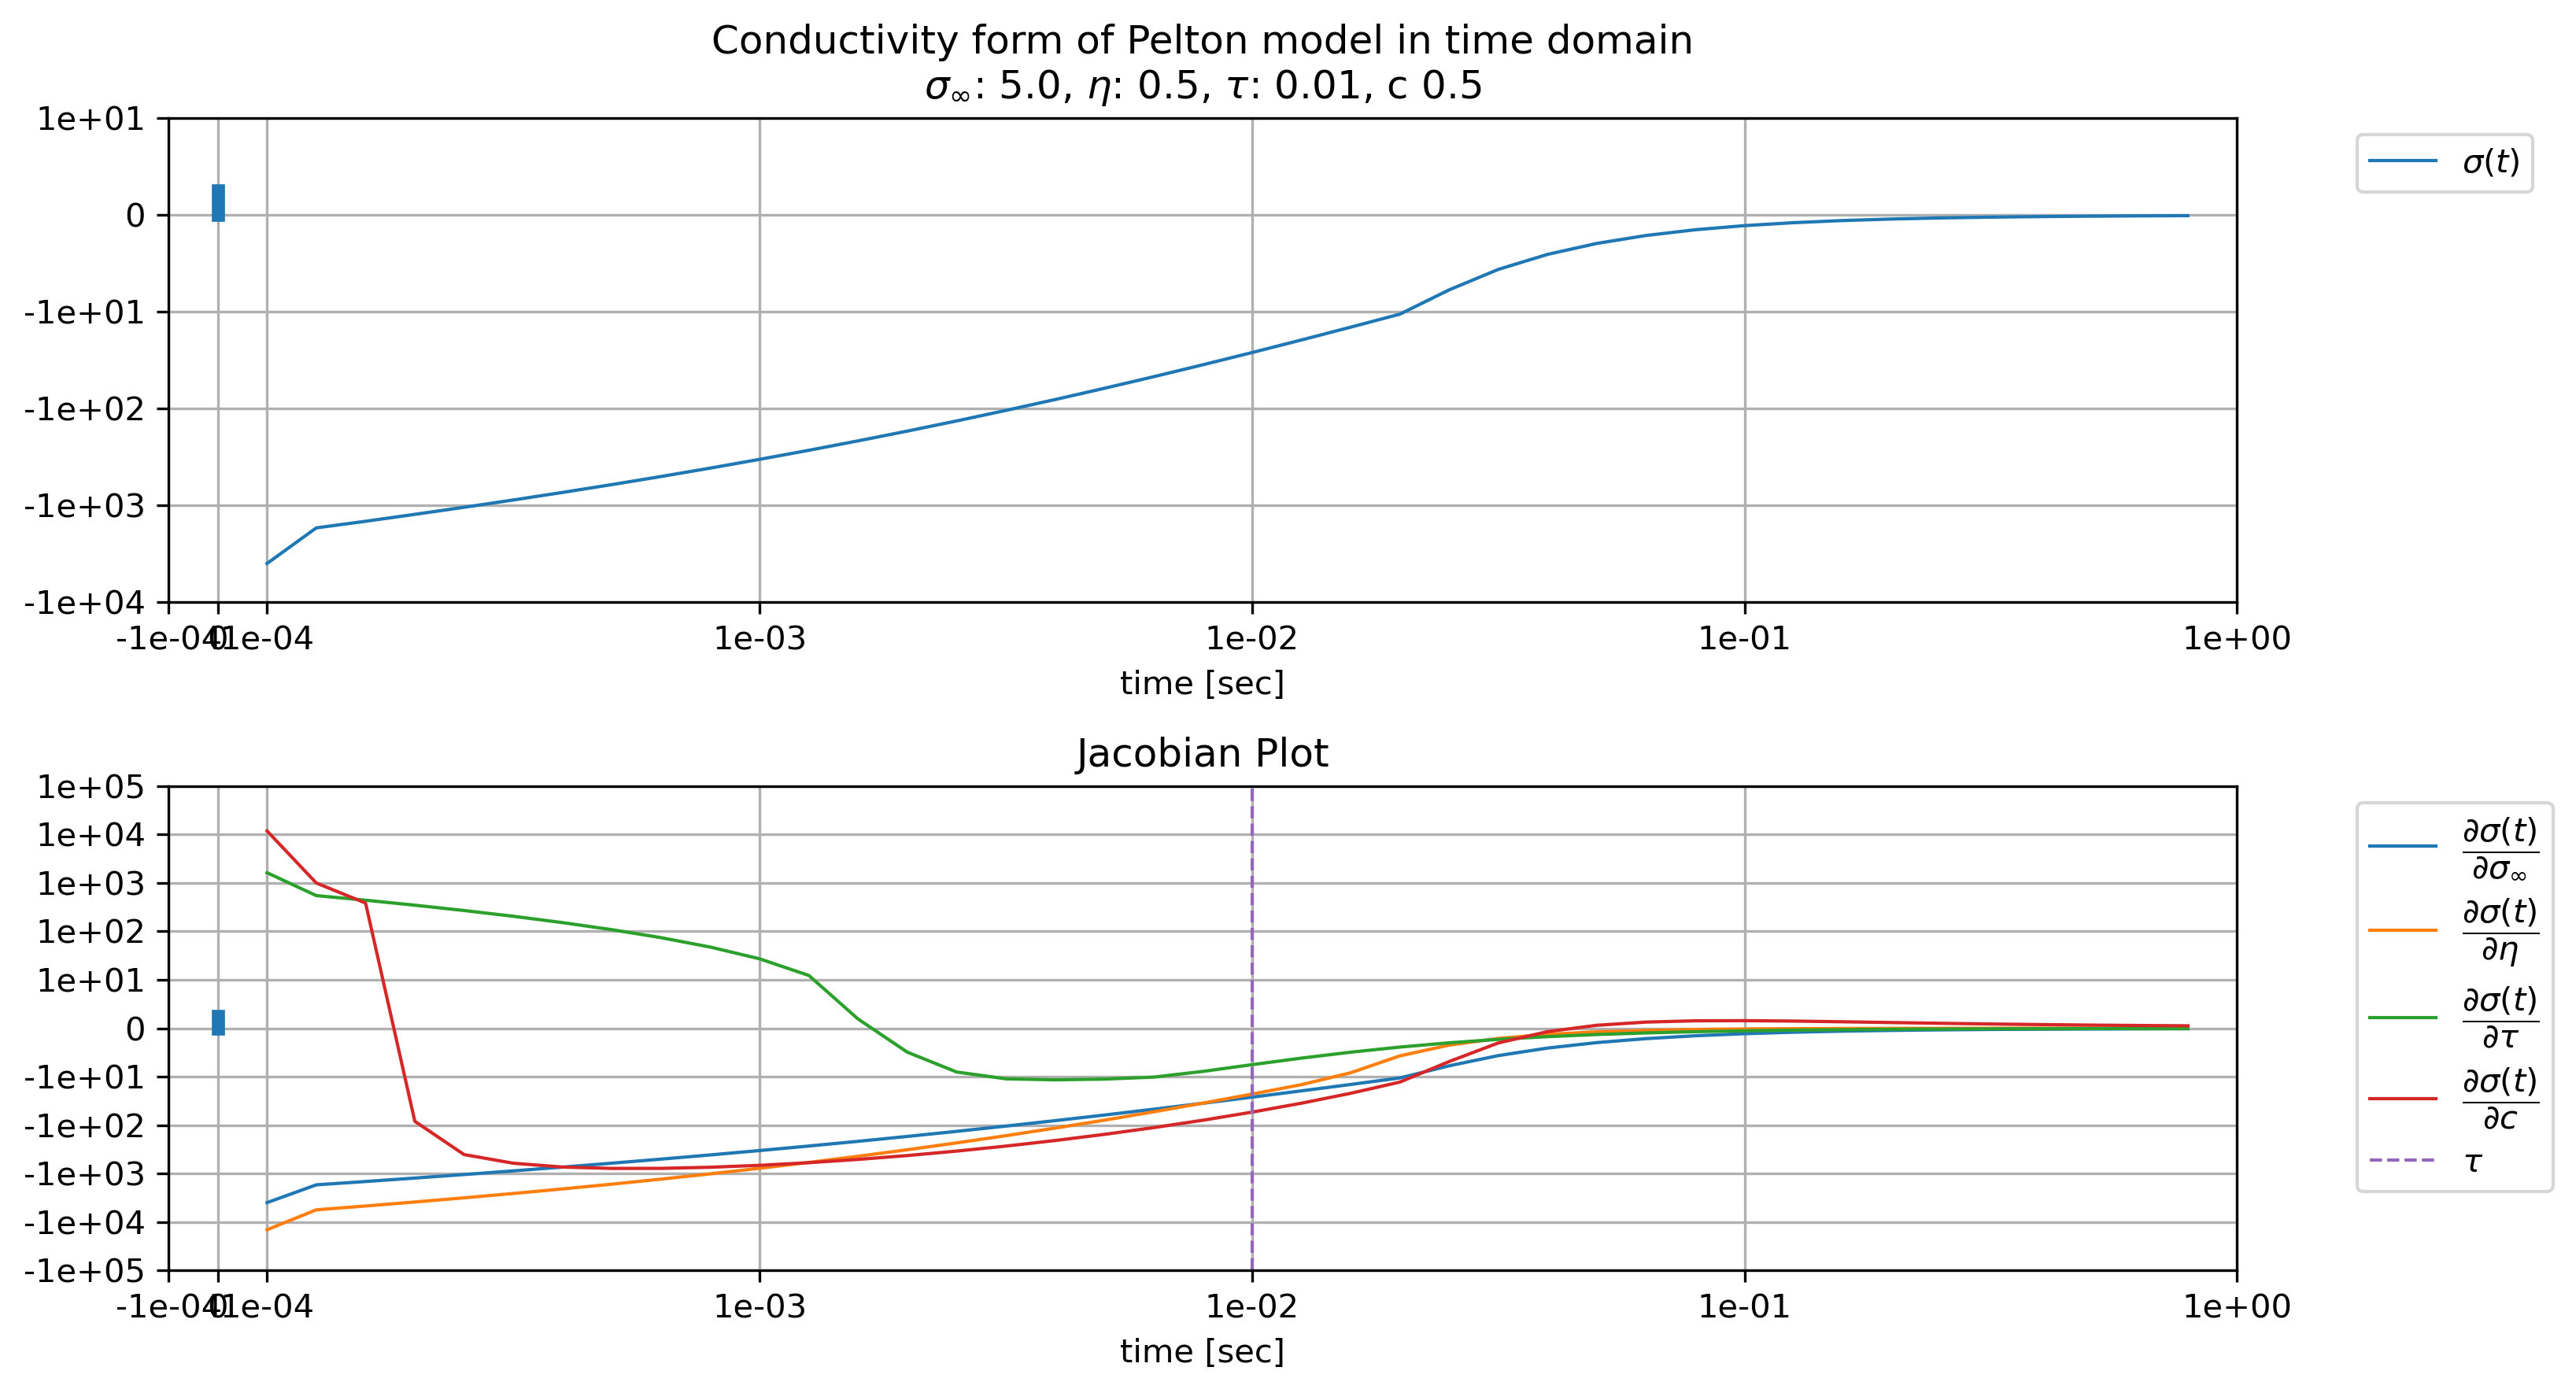

In [103]:
fig, ax = plt.subplots(2, 1, figsize=(11, 6),dpi=300)
ax[0] = PL_pelton.plpl_plot(x=np.r_[0,0], y=np.r_[0,dpred_plot[0]], ax=ax[0], 
                linewidth=4.0,  color="C0") 
ax[0] = PL_pelton.plpl_plot(x=windows_plot[1:], y=dpred_plot[1:], ax=ax[0],
                  color = "C0",label=r"$\sigma(t)$")
PL_pelton.pl_axes(ax=ax[0])
PL_pelton.pl_axes_x(ax=ax[0])
ax[1] = PL_jac.plpl_plot(x=np.r_[0,0], y=np.r_[0,J_plot[0,0]], ax=ax[1], 
                linewidth=4.0,  color="C0" ) 
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,0], ax=ax[1],
                 color = "C0",label=r"$\dfrac{\partial\sigma(t)}{\partial\sigma_\infty}$")
ax[1] = PL_jac.plpl_plot(x=np.r_[0,0], y=np.r_[0,J_plot[0,1]], ax=ax[1],
                linewidth=4.0, color = "C1")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,1], ax=ax[1],
                color = "C1",label=r"$\dfrac{\partial\sigma(t)}{\partial\eta}$")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,2], ax=ax[1],
                color = "C2",label=r"$\dfrac{\partial\sigma(t)}{\partial\tau}$")
ax[1] = PL_jac.plpl_plot(x=windows_plot[1:], y=J_plot[1:,3], ax=ax[1],
                color = "C3",label=r"$\dfrac{\partial\sigma(t)}{\partial c}$")
ax[1] = PL_jac.pl_axvline(ax=ax[1], x=tau, color="C4",label=r'$\tau$')

PL_jac.pl_axes(ax=ax[1])
PL_jac.pl_axes_x(ax=ax[1])
for a in ax:
        a.set_xlabel('time [sec]')
#        a.set_ylabel('Amplitude')
        a.grid(which='both')
        a.legend()
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

        # a.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5, frameon=False)
#        plt.tight_layout(rect=[0, 0.1, 1, 1])
ax[0].set_title(fr"""Conductivity form of Pelton model in time domain
$\sigma_\infty$: {con8}, $\eta$: {eta}, $\tau$: {tau}, c {expc}""")
ax[1].set_title('Jacobian Plot')
plt.tight_layout()
plt.savefig("16_AutoDiffValid_TDlP_Pelton_con.jpg", dpi=300)

In [ ]:
U, S_l, Vh = np.linalg.svd(J_t)
print(S_l)

[2.5589791e+05 1.7894578e+04 5.2062261e+03 6.5058784e+01]


In [ ]:

U, S_s, Vh = np.linalg.svd(J_s)
print(S_s)

[2.5589791e+05 1.7894576e+04 5.2057563e+03 6.3830734e+01]


# Spectrul IP

In [ ]:
freq_strt = 1e-1
freq_end = 1e5
freq_log_stp = 0.1
freq = 10**np.arange(np.log10(freq_strt),np.log10(freq_end)+freq_log_stp,freq_log_stp)
print(freq)
freq_plot = freq

[1.00000000e-01 1.25892541e-01 1.58489319e-01 1.99526231e-01
 2.51188643e-01 3.16227766e-01 3.98107171e-01 5.01187234e-01
 6.30957344e-01 7.94328235e-01 1.00000000e+00 1.25892541e+00
 1.58489319e+00 1.99526231e+00 2.51188643e+00 3.16227766e+00
 3.98107171e+00 5.01187234e+00 6.30957344e+00 7.94328235e+00
 1.00000000e+01 1.25892541e+01 1.58489319e+01 1.99526231e+01
 2.51188643e+01 3.16227766e+01 3.98107171e+01 5.01187234e+01
 6.30957344e+01 7.94328235e+01 1.00000000e+02 1.25892541e+02
 1.58489319e+02 1.99526231e+02 2.51188643e+02 3.16227766e+02
 3.98107171e+02 5.01187234e+02 6.30957344e+02 7.94328235e+02
 1.00000000e+03 1.25892541e+03 1.58489319e+03 1.99526231e+03
 2.51188643e+03 3.16227766e+03 3.98107171e+03 5.01187234e+03
 6.30957344e+03 7.94328235e+03 1.00000000e+04 1.25892541e+04
 1.58489319e+04 1.99526231e+04 2.51188643e+04 3.16227766e+04
 3.98107171e+04 5.01187234e+04 6.30957344e+04 7.94328235e+04
 1.00000000e+05]


In [ ]:
ip_model = Pelton_con_f(freq=freq)
sim_f = InducedPolarizationSimulation(ip_model=ip_model, mode="sip")
dpred_f = sim_f.dpred(parm)
J_f = sim_f.J(parm)
dpred_f_plot = dpred_f.detach().numpy()
dpred_f_plot_real = dpred_f_plot[:len(freq)]
dpred_f_plot_imag = dpred_f_plot[len(freq):]
J_f_plot = J_f.detach().numpy()
J_f_plot_real = J_f_plot[:len(freq),:]
J_f_plot_imag = J_f_plot[len(freq):,:]

In [ ]:
PL_pelton = PsuedoLog(
            logmin=1e-7,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(freq_plot[freq_plot>eps].min())),
            linScalex=0.2)
PL_jac = PsuedoLog(
            logmin=1e-7,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(freq_plot[freq_plot>eps].min())),
            linScalex=0.2)

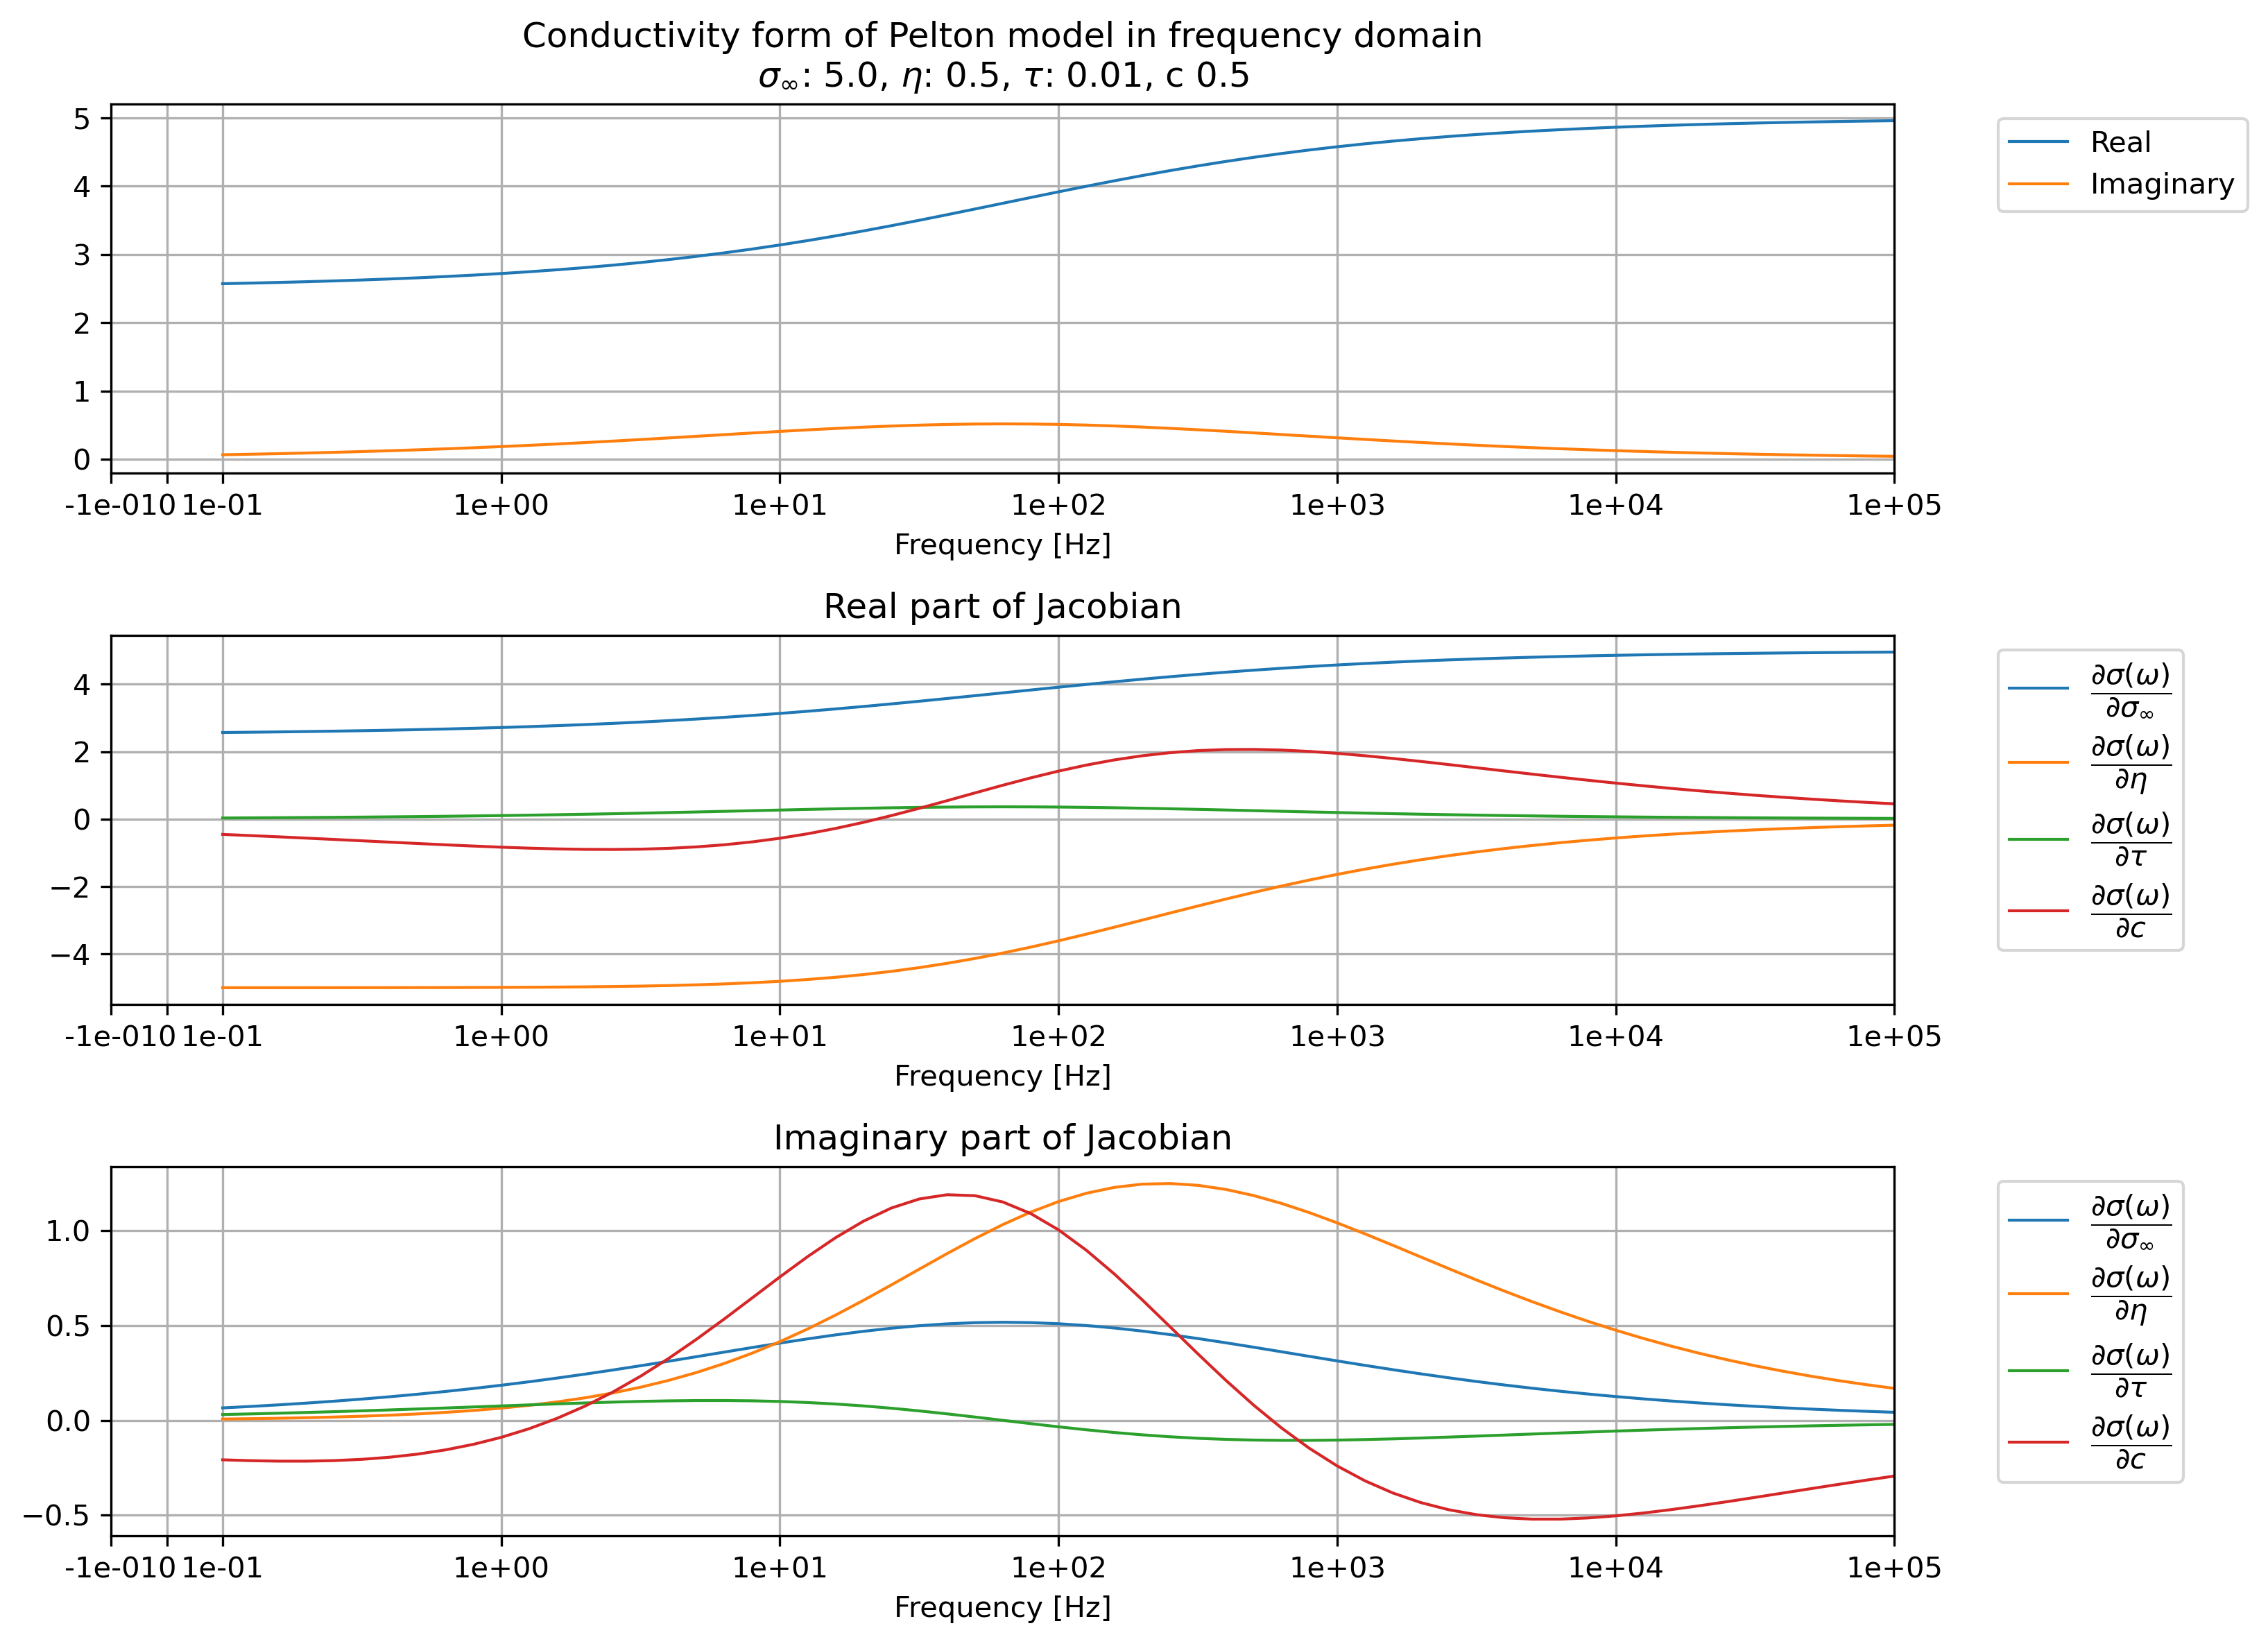

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(11, 8),dpi=300)
ax[0] = PL_pelton.semiplx(x=freq_plot, y=dpred_f_plot_real, ax=ax[0], yscale_log=False,
                          color = "C0",label="Real")
ax[0] = PL_pelton.semiplx(x=freq_plot, y=dpred_f_plot_imag, ax=ax[0], yscale_log=False,
                            color = "C1",label="Imaginary")
PL_pelton.pl_axes_x(ax=ax[0])
ax[1] = PL_jac.semiplx(x=freq_plot, y=J_f_plot_real[:,0], ax=ax[1], yscale_log=False,
                color = "C0",label=r"$\dfrac{\partial \sigma(\omega)}{\partial \sigma_\infty}$")
ax[1] = PL_jac.semiplx(x=freq_plot, y=J_f_plot_real[:,1], ax=ax[1], yscale_log=False,
                color = "C1",label=r"$\dfrac{\partial \sigma(\omega)}{\partial \eta}$")
ax[1] = PL_jac.semiplx(x=freq_plot, y=J_f_plot_real[:,2], ax=ax[1], yscale_log=False,
                color = "C2",label=r"$\dfrac{\partial \sigma(\omega)}{\partial \tau}$")
ax[1] = PL_jac.semiplx(x=freq_plot, y=J_f_plot_real[:,3], ax=ax[1], yscale_log=False,
                color = "C3",label=r"$\dfrac{\partial \sigma(\omega)}{\partial c}$")
PL_jac.pl_axes_x(ax=ax[1])
ax[2] = PL_jac.semiplx(x=freq_plot, y=J_f_plot_imag[:,0], ax=ax[2], yscale_log=False,
                color = "C0",label=r"$\dfrac{\partial \sigma(\omega)}{\partial \sigma_\infty}$")
ax[2] = PL_jac.semiplx(x=freq_plot, y=J_f_plot_imag[:,1], ax=ax[2], yscale_log=False,
                color = "C1",label=r"$\dfrac{\partial \sigma(\omega)}{\partial \eta}$")       
ax[2] = PL_jac.semiplx(x=freq_plot, y=J_f_plot_imag[:,2], ax=ax[2], yscale_log=False,
                color = "C2",label=r"$\dfrac{\partial \sigma(\omega)}{\partial \tau}$")
ax[2] = PL_jac.semiplx(x=freq_plot, y=J_f_plot_imag[:,3], ax=ax[2], yscale_log=False,
                color = "C3",label=r"$\dfrac{\partial \sigma(\omega)}{\partial c}$")
PL_jac.pl_axes_x(ax=ax[2])
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid()
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

ax[0].set_title(fr"""Conductivity form of Pelton model in frequency domain
$\sigma_\infty$: {con8}, $\eta$: {eta}, $\tau$: {tau}, c {expc}""")
ax[1].set_title('Real part of Jacobian')
ax[2].set_title('Imaginary part of Jacobian')
plt.tight_layout()

In [ ]:
U, S_f, Vh = np.linalg.svd(J_f_plot)
print(S_f)

[38.59633    18.224222    6.135115    0.69813454]


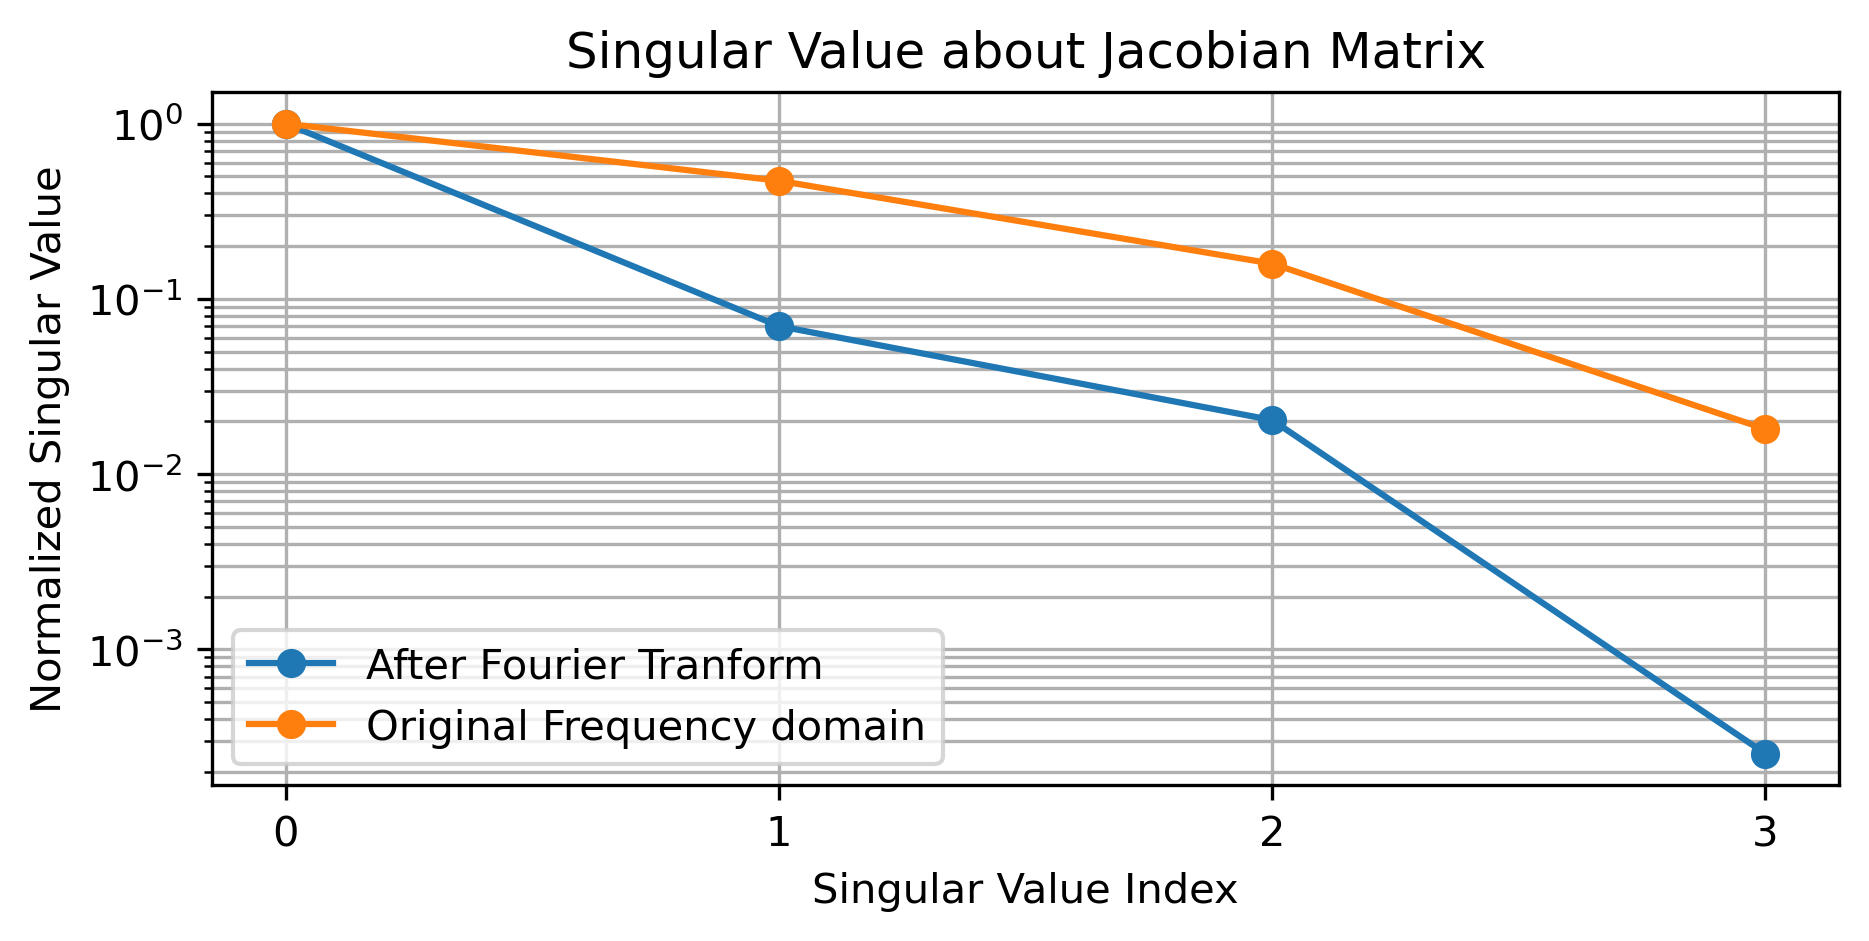

In [ ]:
plt.figure(figsize=(7, 3),dpi=300)
plt.plot(S_l/S_l.max(), label="After Fourier Tranform", marker="o")
plt.plot(S_f/S_f.max(), label="Original Frequency domain", marker="o")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both")
plt.xticks(np.arange(0, S_l.shape[0], 1))
plt.xlabel("Singular Value Index")
plt.ylabel("Normalized Singular Value")
plt.title("Singular Value about Jacobian Matrix")
plt.show()

In [ ]:
print(J_l.shape)

(41, 4)


In [ ]:
print(J_s.shape)

(21, 4)
